# Event Detection Affine Projection Algorithms

For the eye activation detection task, there is a clear trend in the data - measuring the data with open eyes outputs a clearly different DC Voltage than measuring the data with eyes closed. This can be observed in the sample data below.

### Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#Digilent WaveForms Oscilloscope Acquisition
#Device Name: Discovery2
#Serial Number: SN:210321B5D9FA
#Date Time: 2025-02-13 12:33:16.223
#Sample rate: 136.533Hz
#Samples: 5800
#Trigger: Source: Channel 1 Type: Edge Condition: Rising Level: 0 V Hyst.: Auto HoldOff: 0 s
#Channel 1: Range: 200 mV/div Offset: -2 V Sample Mode: Average
#Channel 2: Range: 500 mV/div Offset: 0 V Sample Mode: Average
#Power Supplies: ON
#Positive Supply: ON
#Voltage: 5 V
#Negative Supply: ON
#Voltage: -5 V

## Probabilistic Non-Linearity

In [ ]:
# Sigmoid
def sigmoid(x):
    return 1/(1+np.exp(-x))

# Derivative of Sigmoid
def sigmoid_derivative(x):
    return x*(1-x)

## EDAPA Calculations

In [ ]:
# EDNLMS Filter
def apply_ednlms_filter(x_in, w_lms_k, d, mu=None, eps=None):
    """
    Applies the EDNLMS filter to the input signal x_in using C-loss.

    x_in: input signal (M x 1)
    w_lms_k: filter weights at time k (M x 1)
    d: desired output signal (scalar)
    mu: learning rate
    eps: regularization parameter
    """
    if mu is None:
        raise ValueError("mu must be specified.")
    if eps is None:
        raise ValueError("eps must be specified.")
    
    v_hat = np.dot(w_lms_k, x_in)
    y_hat = sigmoid(v_hat)
    e = d - y_hat
    x_pow  = np.dot(x_in, x_in)
    mu_eff = mu / (x_pow + eps)
    w_lms_k1 = w_lms_k + mu_eff * e * x_in

    return y_hat, w_lms_k1, mu_eff, e
def ednlms_filter_full(x_in, d, M, mu, eps=1e-15):
    """
    Basic NLMS for system ID. Returns final filter after N updates.
    """
    N = len(x_in)
    x_eff = np.pad(x_in, (M, 0), mode='constant')
    x_eff = x_eff[:-1]
    y_hat = np.zeros(N)
    w_hist = np.zeros((N, M))
    mu_eff_hist = np.zeros(N)
    e_hist = np.zeros(N)
    for n in range(N):
        x_vec = x_eff[n:n+M]
        y_hat[n], w_hist[n], mu_eff_hist[n], e_hist[n] = apply_ednlms_filter(x_vec, w_hist[n-1], d[n], mu, eps)
        
    return w_hist, y_hat, mu_eff_hist, e_hist

# VSS-APA Filter
def apply_edvss_apa_filter(X, d_vec, w, mu, delta):
    """
    Applies one iteration of the VSS-APA filter.
    
    Parameters:
      X: np.ndarray of shape (M, P) - input data matrix.
      d_vec: np.ndarray of shape (P,) - desired (future) output vector.
      w: np.ndarray of shape (M,) - current filter weight vector.
      mu: float - current step size.
      delta: float - regularization parameter.
      
    Returns:
      w_new: updated weight vector (M,)
      y_vec: output vector computed as X.T @ w (P,)
      e: error vector (P,)
    """
    v_vec = X.T @ w  # shape: (P,)
    y_vec = sigmoid(v_vec)  # output vector
    e = d_vec - y_vec  # error vector

    # Compute the inversion term: (X.T @ X + delta * I)
    A = X.T @ X + delta * np.eye(X.shape[1])
    A_inv = np.linalg.inv(A)

    # Update the weight vector according to the APA rule
    w_new = w + mu * (X @ (A_inv @ e))
    return w_new, y_vec, e
def edvss_apa_filter_full(x, d, M, P, mu0, delta, mu_min, mu_max, rho, eta, 
                        alpha=0.9, beta=0.8, w_init=None, mu_init=None, 
                        num_predictions=None, prediction_horizon=1):
    """
    Apply the Variable Step-Size Affine Projection Algorithm (VSS-APA) for future sample prediction.
    
    Parameters:
      x: 1D NumPy array of input samples.
      d: 1D NumPy array of desired outputs.
      M: Filter order (length of the adaptive filter).
      P: Projection order (number of past input vectors used for the update).
      mu0: Initial step size.
      delta: Regularization parameter.
      mu_min: Minimum allowed step size.
      mu_max: Maximum allowed step size.
      rho: Adaptation rate for the step size.
      eta: Target error energy threshold for step size adaptation.
      alpha: Exponential smoothing factor for error energy (default 0.9).
      beta: Momentum factor for step-size adaptation (default 0.8).
      w_init: Optional initial weight vector.
      mu_init: Optional initial step size.
      num_predictions: Optional number of predictions to perform.
      prediction_horizon: int - how many steps ahead to predict (default=1 for one-step ahead).
      
    Returns:
      predictions: 1D NumPy array of future predictions.
      weight_history: 2D NumPy array with each row as the filter weights at each iteration.
      mu_history: 1D NumPy array of step sizes over iterations.
      error_history: 2D NumPy array of error vectors for each iteration.
    """
    # start_index is chosen so that we have enough past samples for X and future samples for prediction
    start_index = M + P - 1
    if num_predictions is None:
        num_predictions = len(x) - (start_index + prediction_horizon)
    
    predictions = np.zeros(num_predictions)
    weight_history = np.zeros((num_predictions, M))
    mu_history = np.zeros(num_predictions)
    error_history = np.zeros((num_predictions, P))
    
    w = w_init.copy() if w_init is not None else np.zeros(M)
    mu = mu_init if mu_init is not None else mu0
    error_energy_prev = eta  # Initialize with target error threshold
    
    for k in range(start_index, start_index + num_predictions):
        # Construct the input matrix X (shape: M × P)
        X = np.zeros((M, P))
        for p in range(P):
            idx_end = k - p
            idx_start = idx_end - M + 1
            X[:, p] = x[idx_start: idx_end + 1]
        
        # For future prediction, set the desired output vector to the future samples.
        # For one-step ahead prediction (prediction_horizon=1), this yields d[k+1] in the first column.
        d_vec = np.array([d[k + prediction_horizon - p] for p in range(P)])
        
        # Apply one iteration of the VSS-APA update
        w, y_vec, e = apply_edvss_apa_filter(X, d_vec, w, mu, delta)
        
        # The prediction corresponds to the future sample for the first column
        predictions[k - start_index] = y_vec[0]
        weight_history[k - start_index] = w
        error_history[k - start_index] = e

        # Compute the smoothed error energy using exponential smoothing
        error_energy = np.linalg.norm(e)**2
        error_energy_smoothed = alpha * error_energy_prev + (1 - alpha) * error_energy

        # Compute RMS-based normalized update
        rms_error = np.sqrt(np.mean(e**2) + 1e-6)  # Prevents division by zero
        mu_update = rho * (error_energy_smoothed - eta) / (rms_error + 1e-6)

        # Apply momentum term for smoother step-size updates
        mu = beta * mu + (1 - beta) * mu_update

        # Ensure mu remains within the specified bounds
        mu = np.clip(mu, mu_min, mu_max)
        mu_history[k - start_index] = mu

        error_energy_prev = error_energy_smoothed
    
    return predictions, weight_history, mu_history, error_history

## APA Prototype Experiments (Python)

#### NLMS

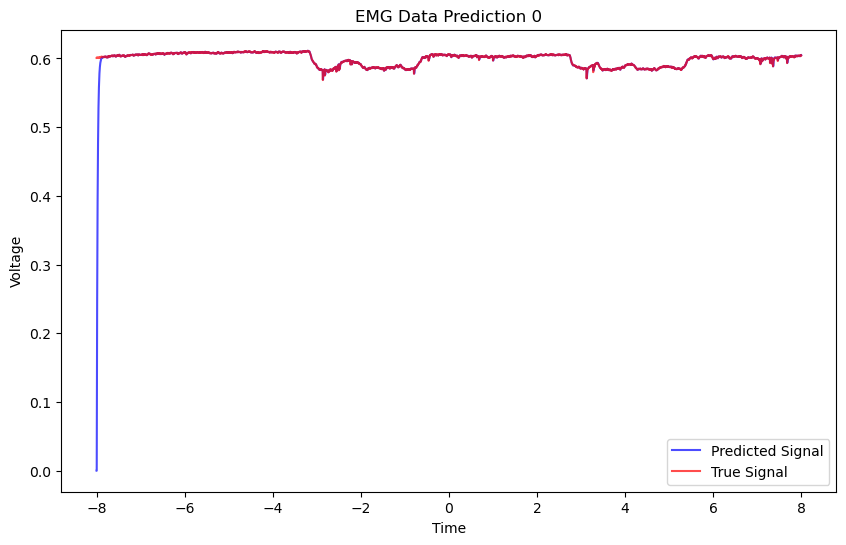

NMSE: 0.02808550607064804


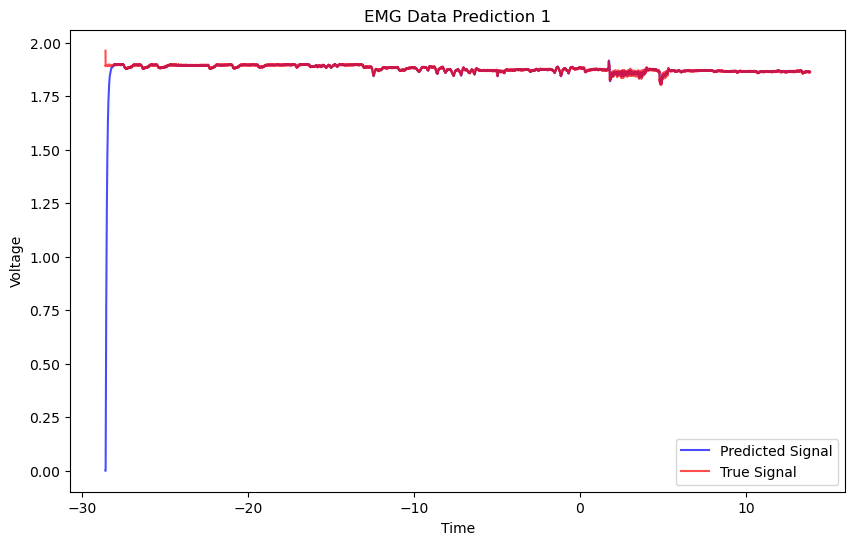

NMSE: 0.03353226120671323


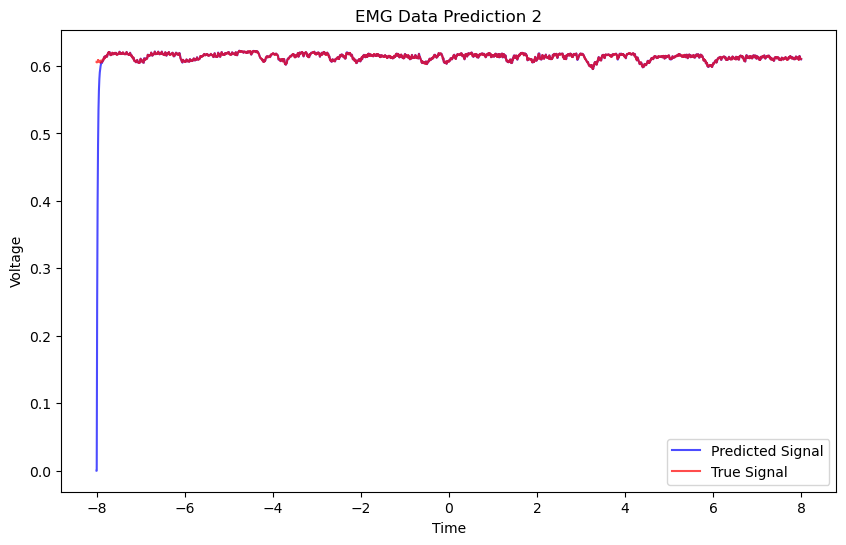

NMSE: 0.02766927696304644


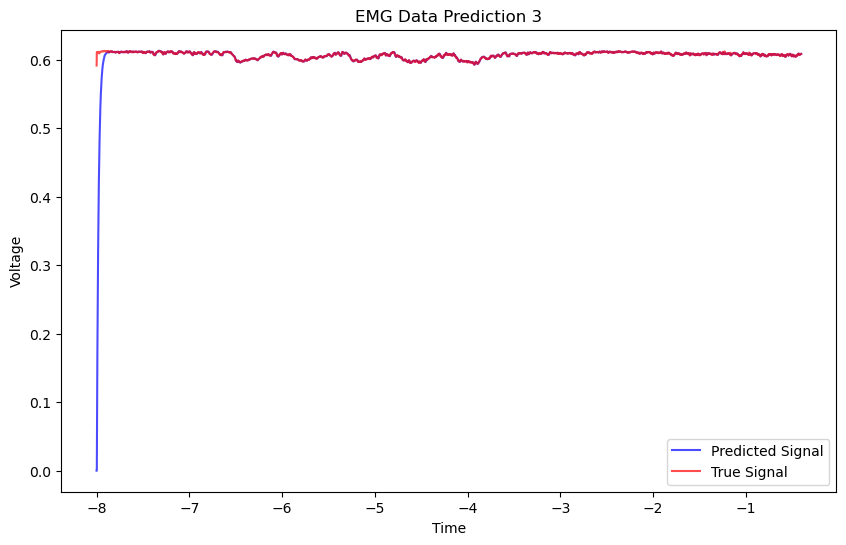

NMSE: 0.04049623054732222


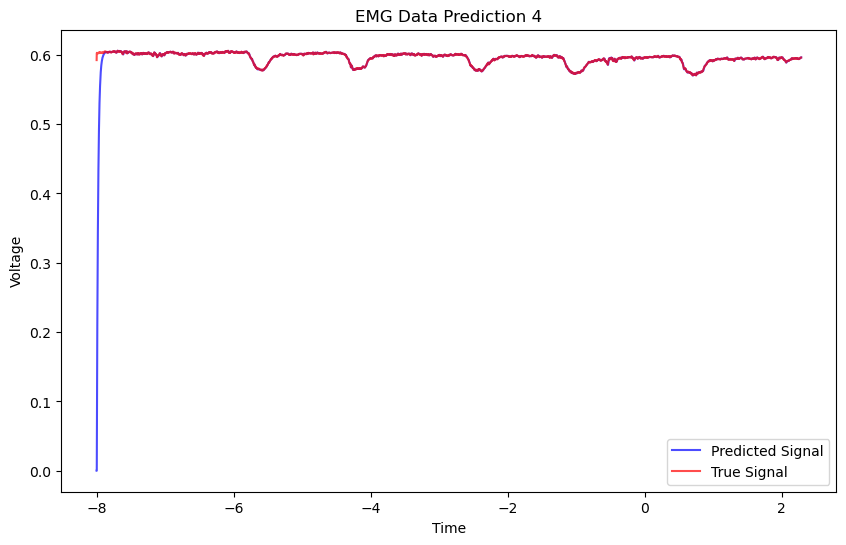

NMSE: 0.03512828069713382


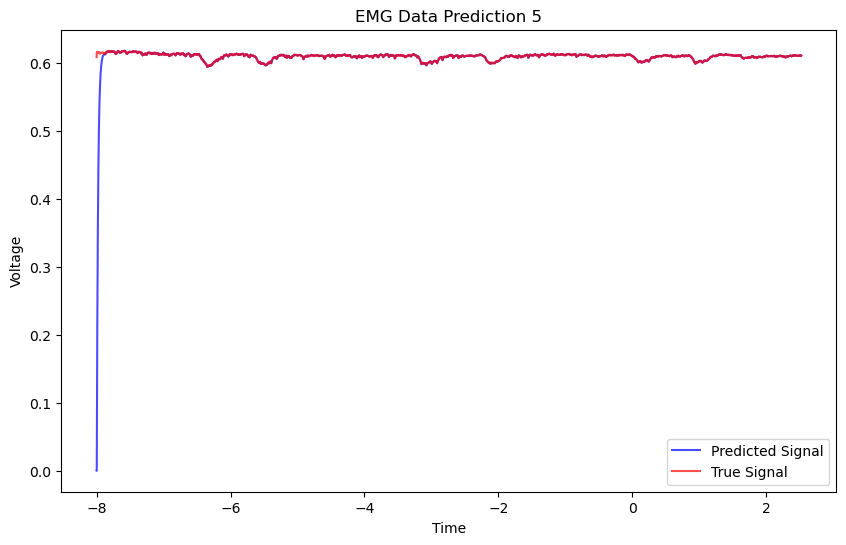

NMSE: 0.03473029956135192


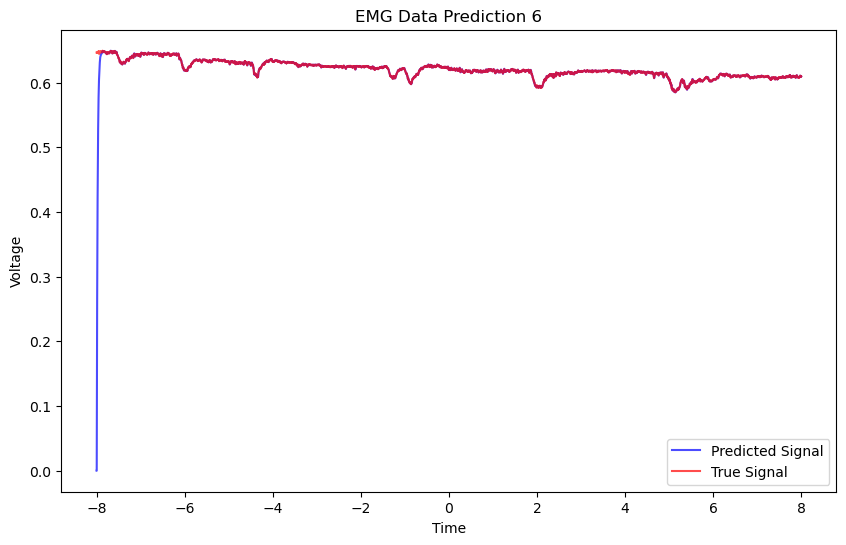

NMSE: 0.02915336306567855


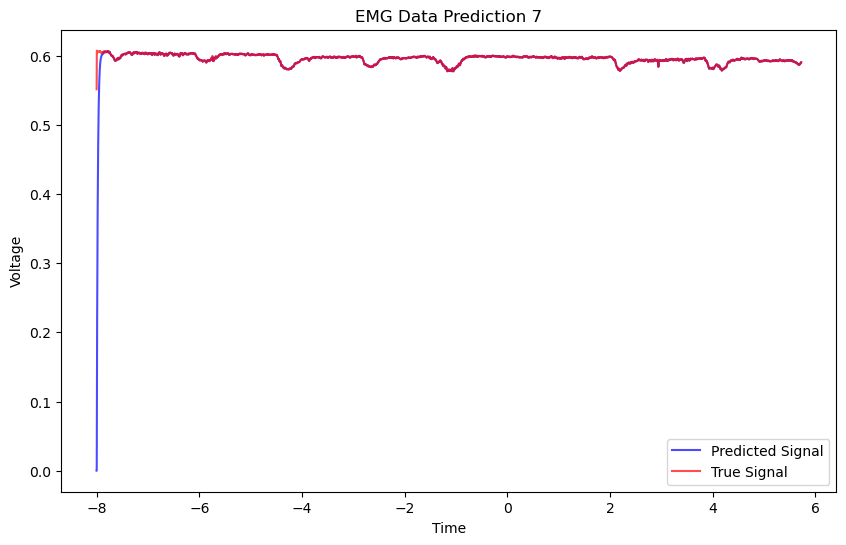

NMSE: 0.029946843919220822


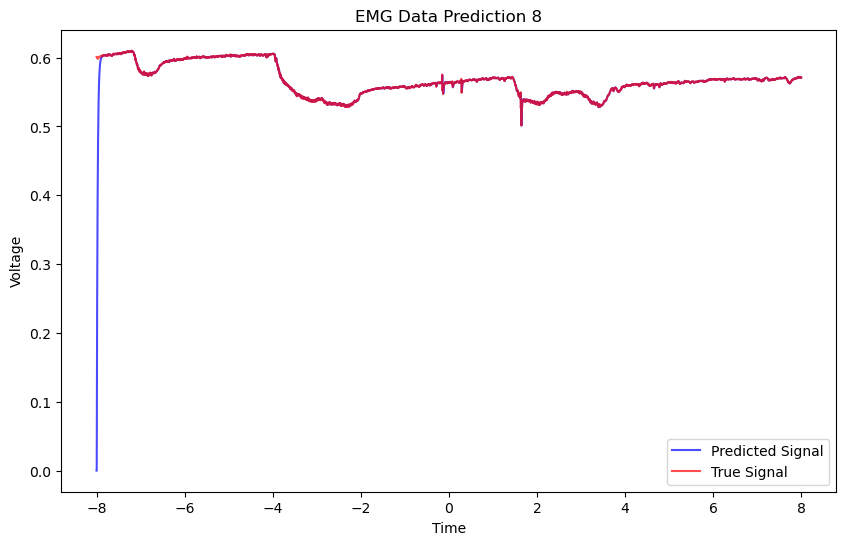

NMSE: 0.029639619309678497


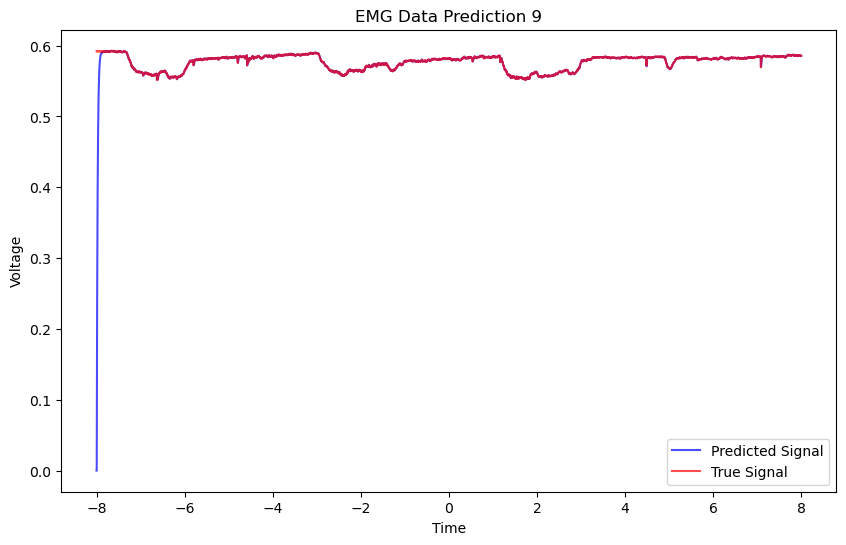

NMSE: 0.02872819009077448


In [ ]:
M = 4
mu = 0.1

for i in range(10):
    # Load the data
    data = pd.read_csv(f'eye_blinking{i}.csv', delimiter=',')
    # Drop Channel2
    data = data.drop(columns=['Channel2'])
    voltage = data['Channel1']
    time = data['Time']
    N = len(voltage)
    # Apply the filter
    w_hist, y_hat, mu_eff_hist, e_hist = ednlms_filter_full(voltage, voltage, M, mu)

    # Plot the event detection
    plt.figure(figsize=(10, 6))
    plt.plot(time, y_hat, 'b', label='Predicted Signal', alpha=0.7)
    plt.plot(time, voltage, 'r', label='True Signal', alpha=0.7)
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('Voltage')
    plt.title(f'EMG Data Prediction {i}')
    plt.show()

    nmse = np.linalg.norm(e_hist) / np.linalg.norm(voltage)
    print(f'NMSE: {nmse}')

### NLMS Evaluation Experiment (C)

To use the C code, download the NLMS.C file, and compile with the corresponding compiler. For Linux, the command:
```
gcc NLMS.C -o nlms -lm
./nlms
```

Can validate the results obtained above on your own dataset. For real-time functions, the ```apply_nlms``` function should be used in an online-fashion. This means, it can and should be used per input received.

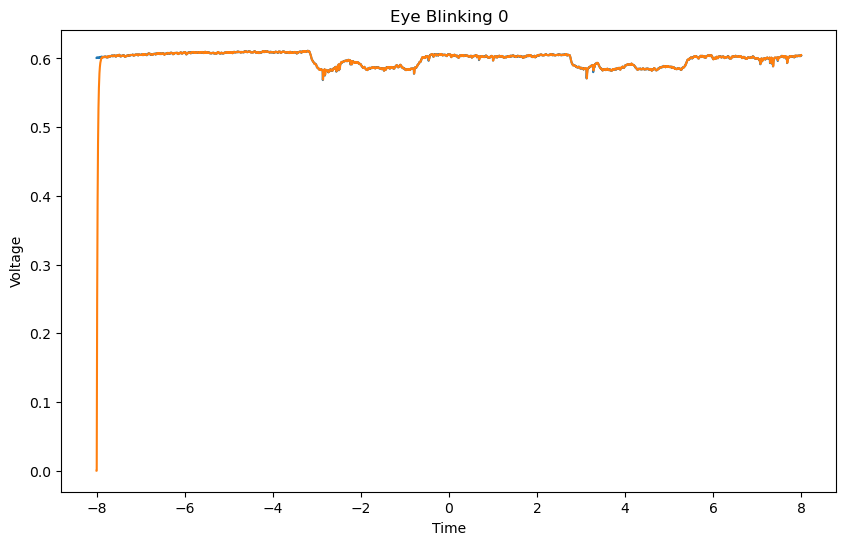

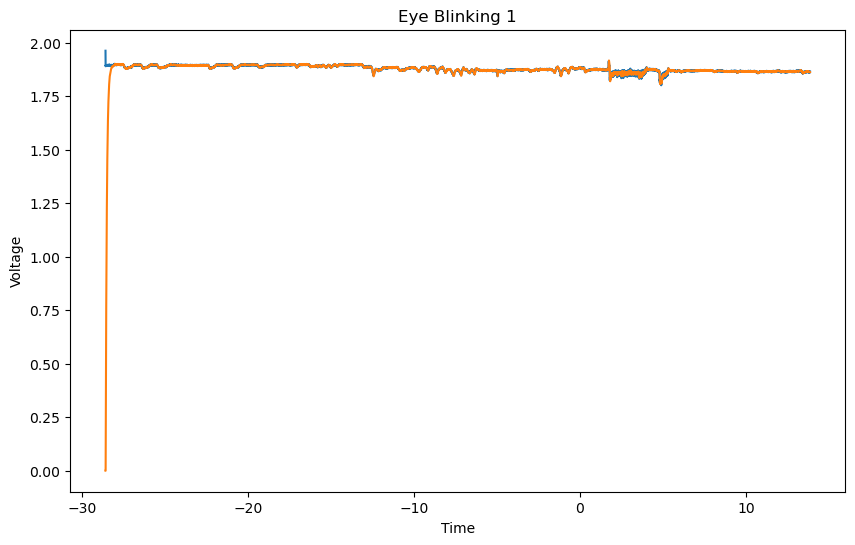

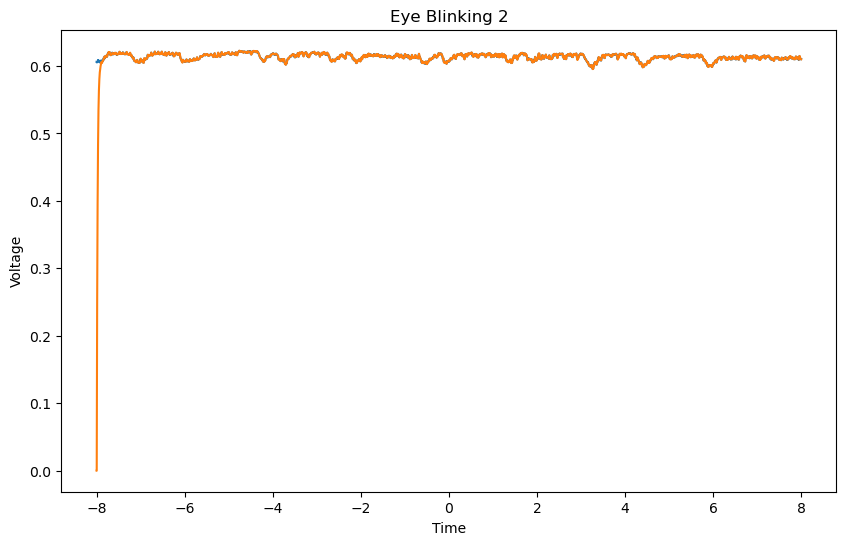

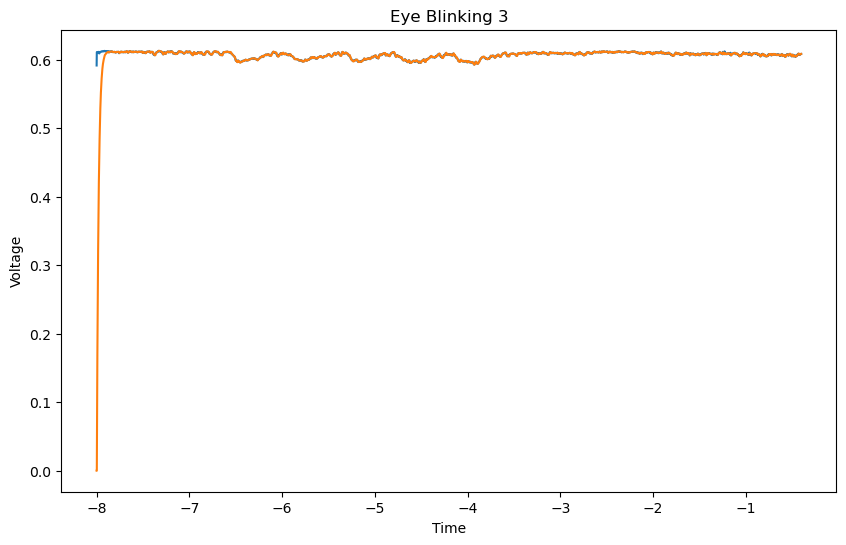

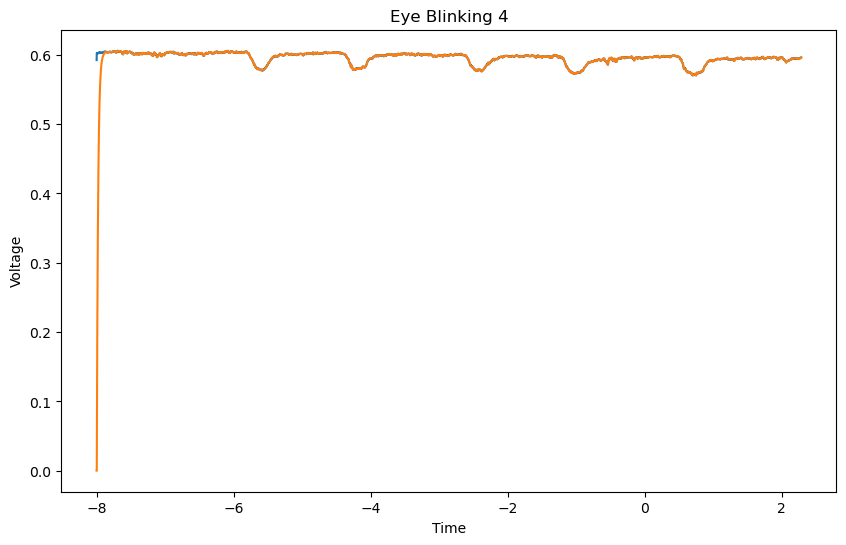

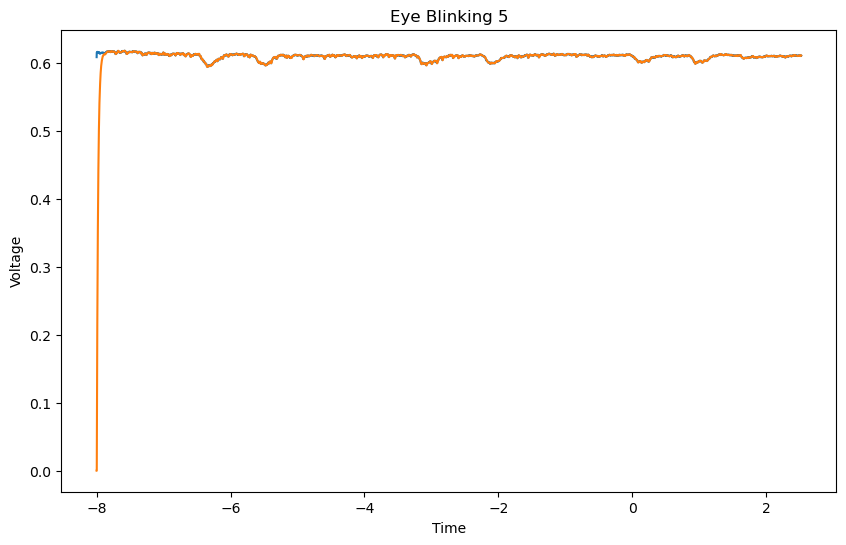

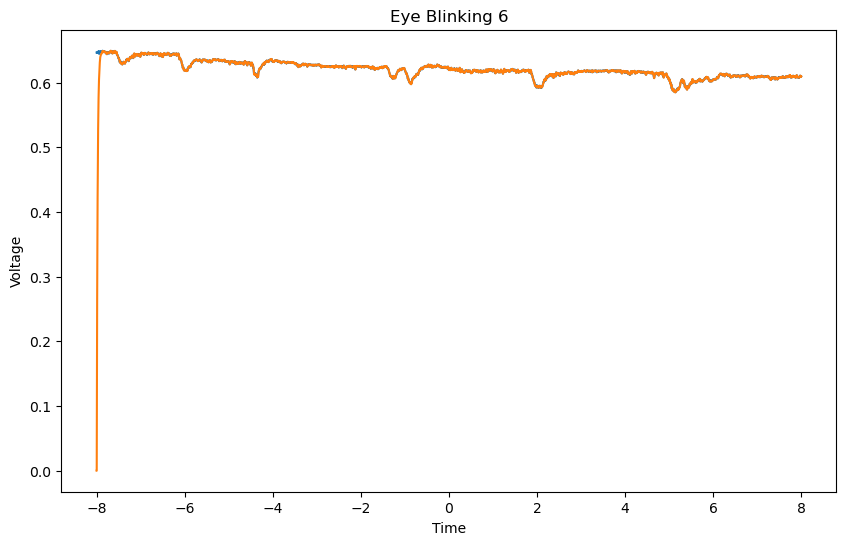

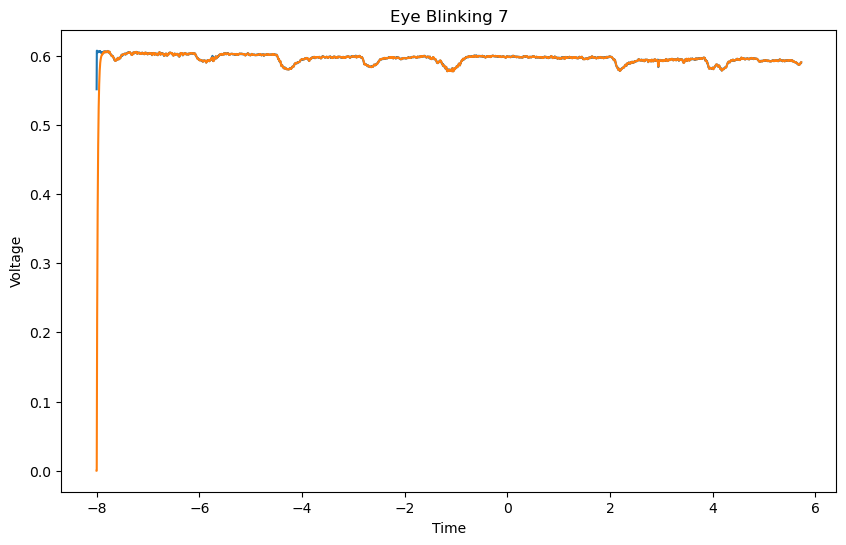

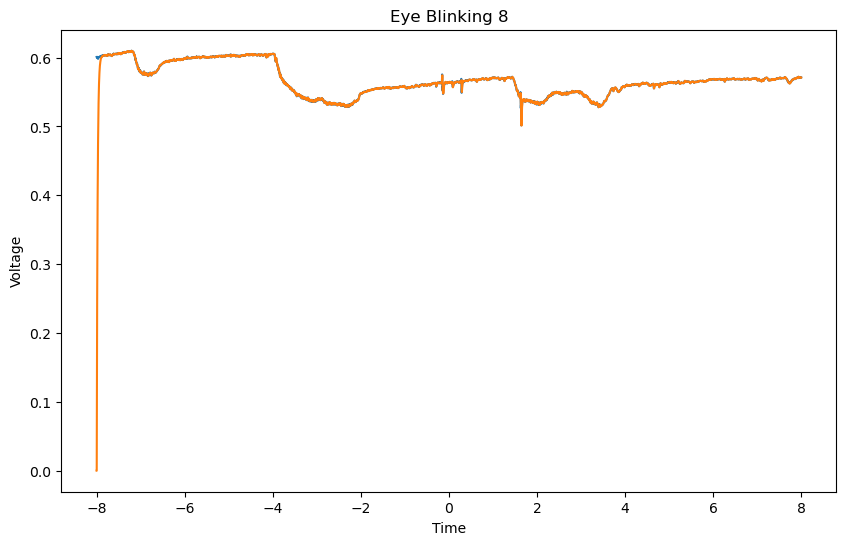

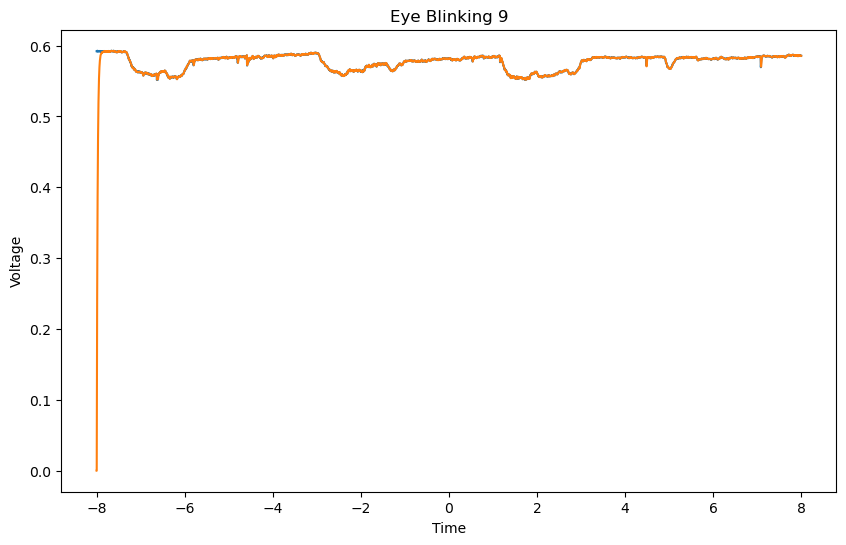

In [5]:
for i in range(10):
    data = pd.read_csv(f'output{i}.csv', delimiter=',')

    plt.figure(figsize=(10, 6))
    plt.plot(data['Time'], data['TrueVoltage'])
    plt.plot(data['Time'], data['Prediction'])

    plt.title(f'Eye Blinking {i}')
    plt.xlabel('Time')
    plt.ylabel('Voltage')
    plt.title(f'Eye Blinking {i}')
    plt.show()


### VSS-APA

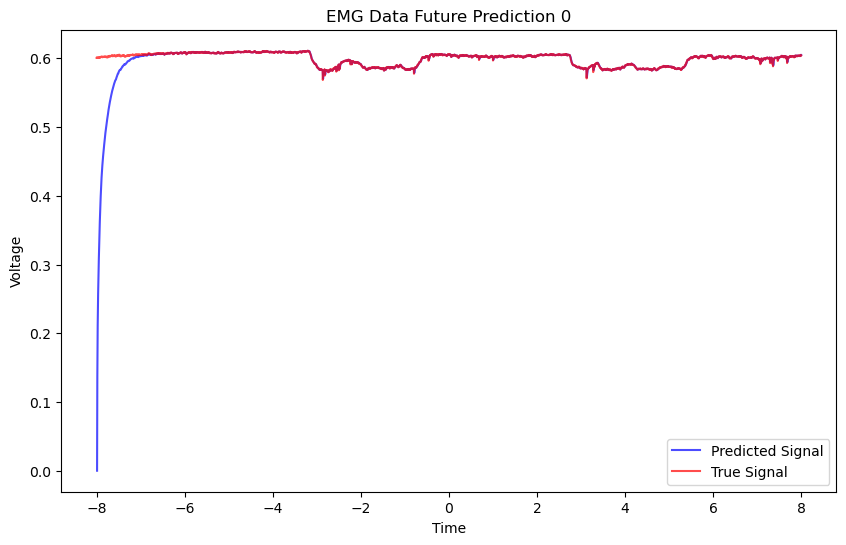

NMSE for file 0: 0.04686714142726235


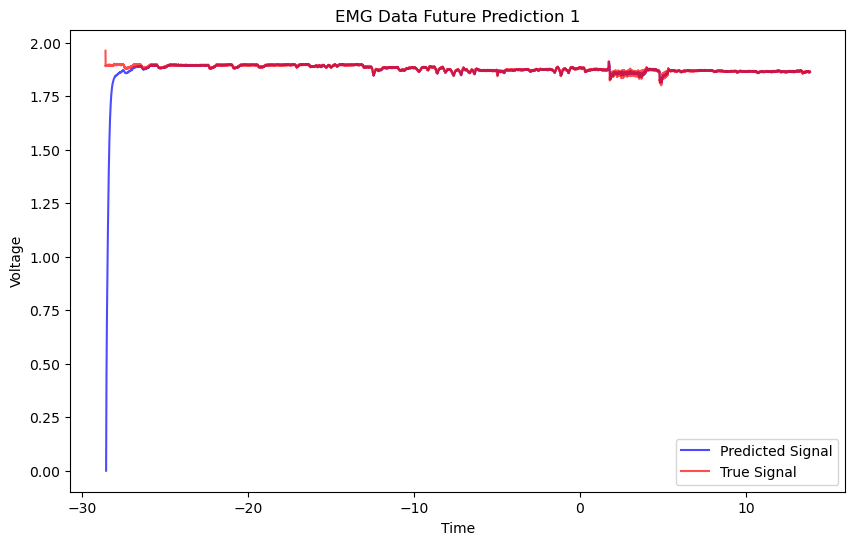

NMSE for file 1: 0.03777143782574375


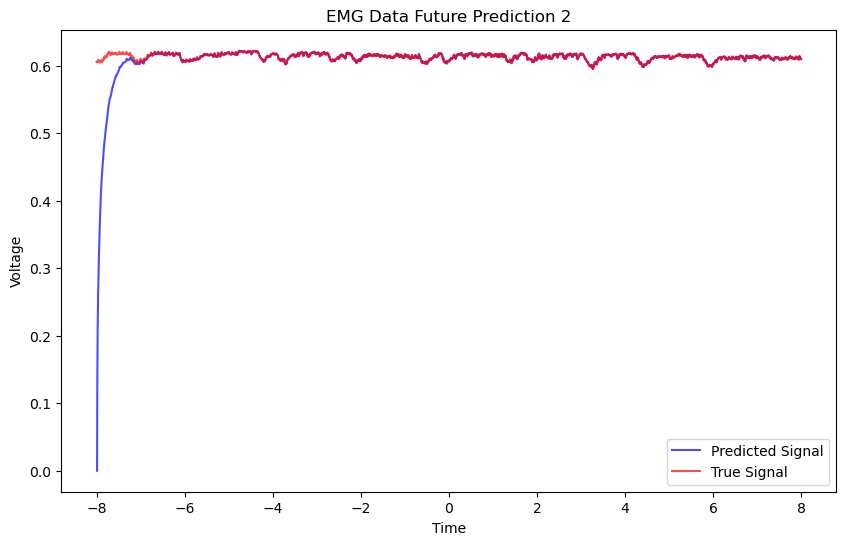

NMSE for file 2: 0.04613222373844637


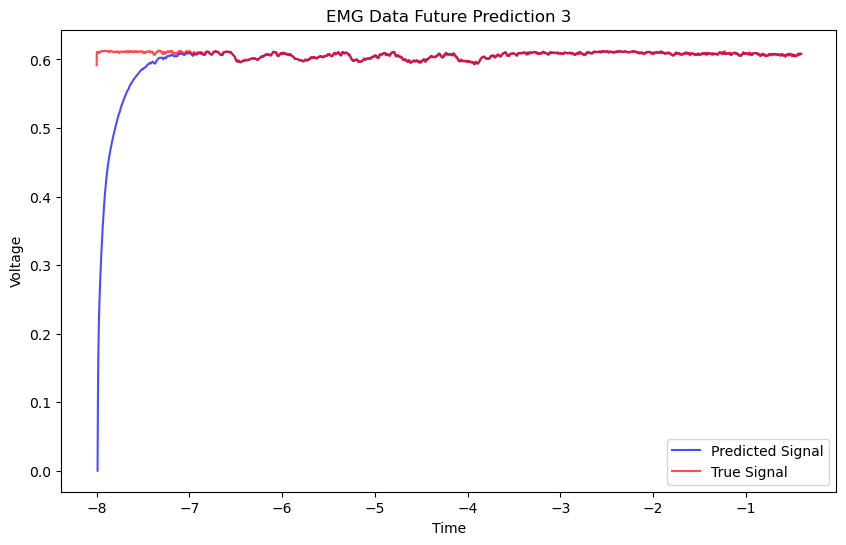

NMSE for file 3: 0.06787387904838565


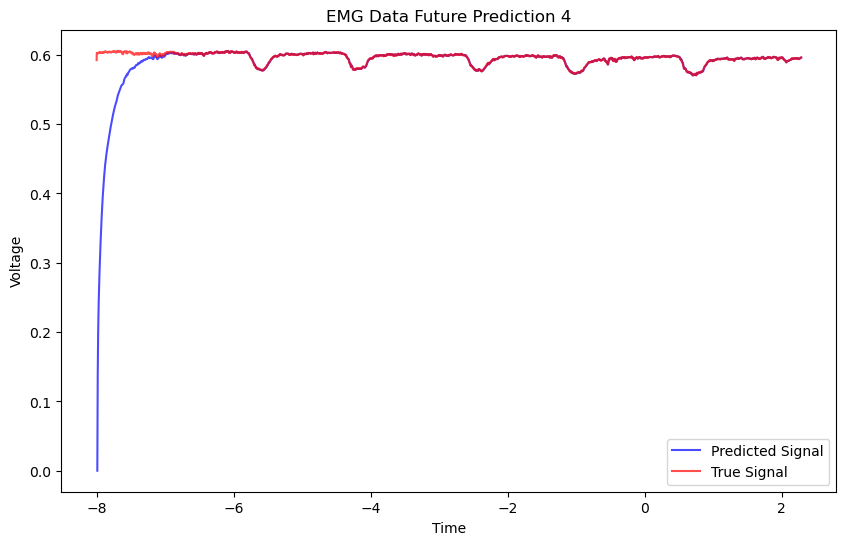

NMSE for file 4: 0.058899896678715084


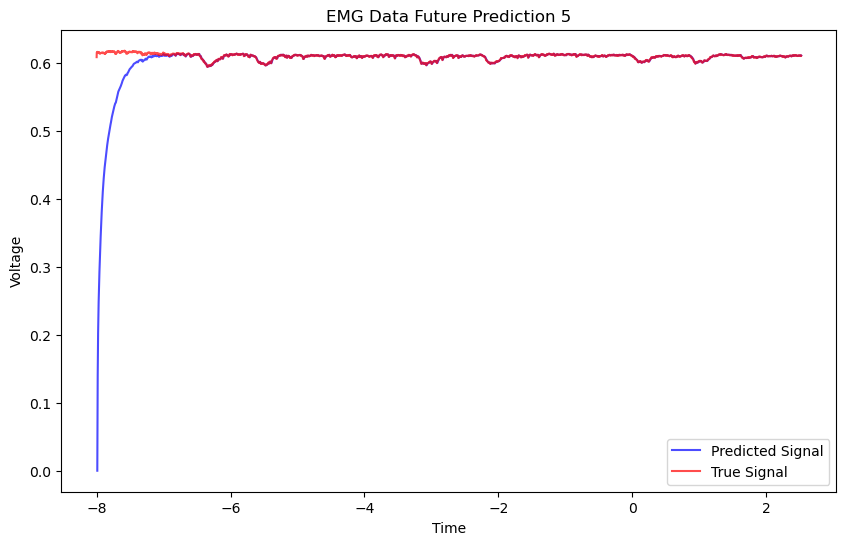

NMSE for file 5: 0.0576562579166258


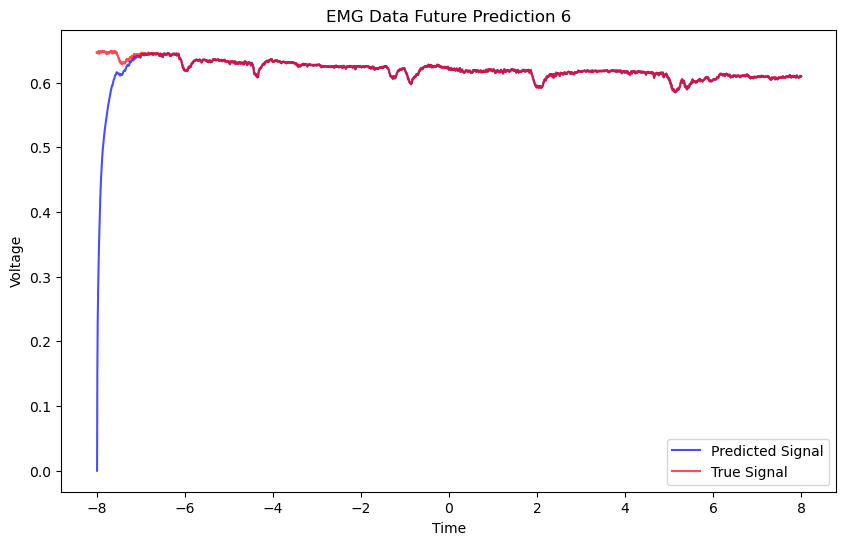

NMSE for file 6: 0.0474681427487133


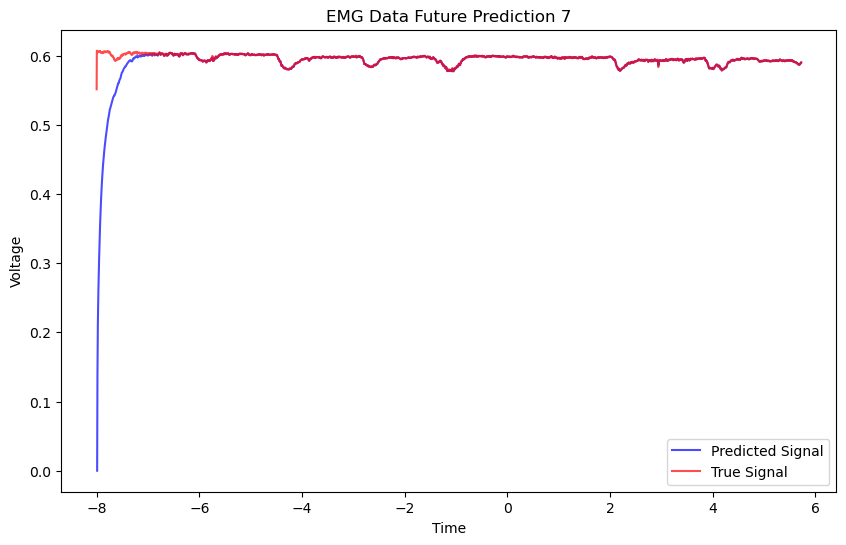

NMSE for file 7: 0.051085261107397806


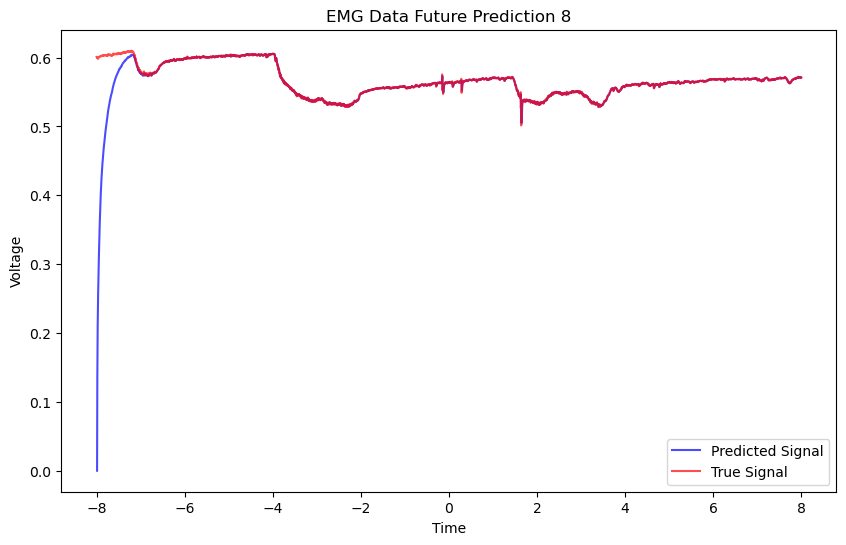

NMSE for file 8: 0.049494346702209174


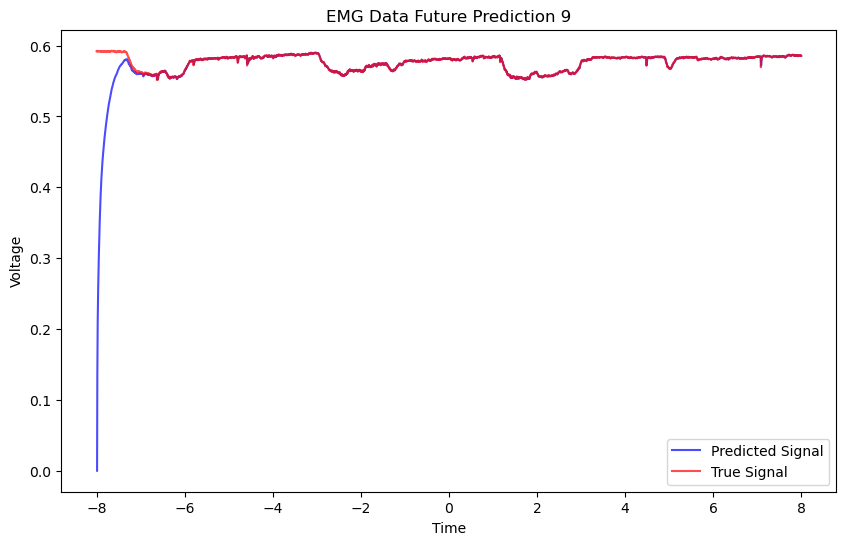

NMSE for file 9: 0.048121807303847276


In [6]:
M = 4                   # Filter order
mu0 = 0.1               # Initial step size
P = 1                   # Projection order (using one past input block for one-step prediction)
delta = 0.001           # Regularization parameter
mu_min = 0.01           # Minimum step size
mu_max = 1.0            # Maximum step size
rho = 0.05              # Step-size adaptation rate
eta = 0.001             # Target error energy
prediction_horizon = 1  # One-step ahead prediction

for i in range(10):
    # Load the data
    data = pd.read_csv(f'eye_blinking{i}.csv', delimiter=',')
    # Drop Channel2 if present
    if 'Channel2' in data.columns:
        data = data.drop(columns=['Channel2'])
    voltage = data['Channel1'].to_numpy()
    time = data['Time'].to_numpy()
    
    # Apply the VSS-APA filter for future sample prediction.
    predictions, weight_history, mu_history, error_history = vss_apa_filter_full(
        voltage, voltage, M, P, mu0, delta, mu_min, mu_max, rho, eta, 
        prediction_horizon=prediction_horizon
    )
    
    # Adjust the time axis for predictions.
    # The predictions correspond to the sample at index (start_index + prediction_horizon)
    start_index = M + P - 1 + prediction_horizon
    pred_time = time[start_index: start_index + len(predictions)]
    
    # Plot the future prediction vs. the true signal
    plt.figure(figsize=(10, 6))
    plt.plot(pred_time, predictions, 'b', label='Predicted Signal', alpha=0.7)
    plt.plot(time, voltage, 'r', label='True Signal', alpha=0.7)
    plt.xlabel('Time')
    plt.ylabel('Voltage')
    plt.title(f'EMG Data Future Prediction {i}')
    plt.legend()
    plt.show()
    
    # Compute and print the NMSE (using the corresponding segment of the true signal)
    nmse = np.linalg.norm(error_history) / np.linalg.norm(voltage[start_index: start_index+len(predictions)])
    print(f'NMSE for file {i}: {nmse}')


### VSS-APA Evaluation Experiment (C)

To use the C code, download the VSSAPA.C file, and compile with the corresponding compiler. For Linux, the command:
```
gcc VSSAPA.C -o vssapa -lm
./vssapa
```

Can validate the results obtained above on your own dataset. For real-time functions, the ```apply_vssapa``` function should be used in an online-fashion. This means, it can and should be used per input received.

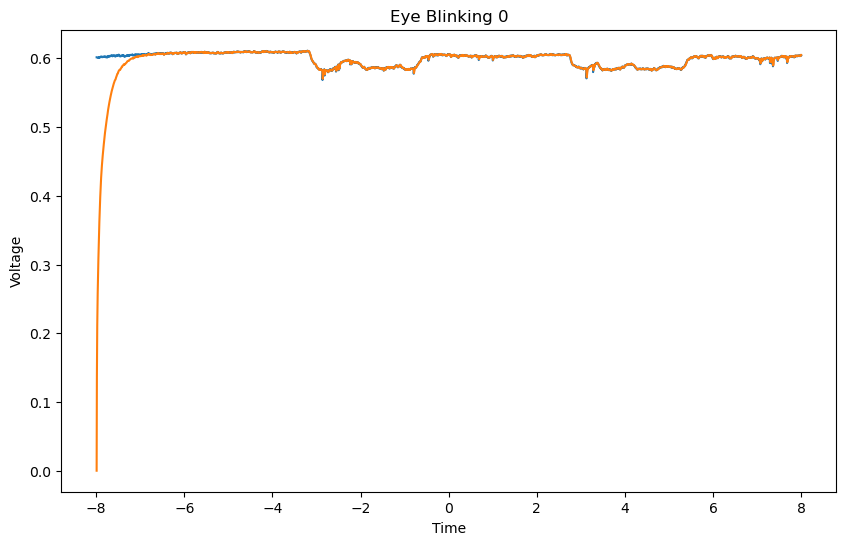

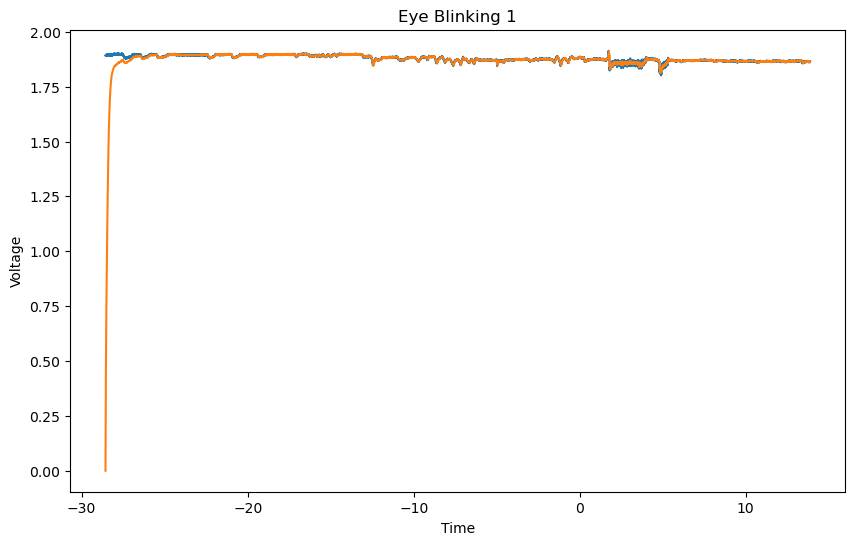

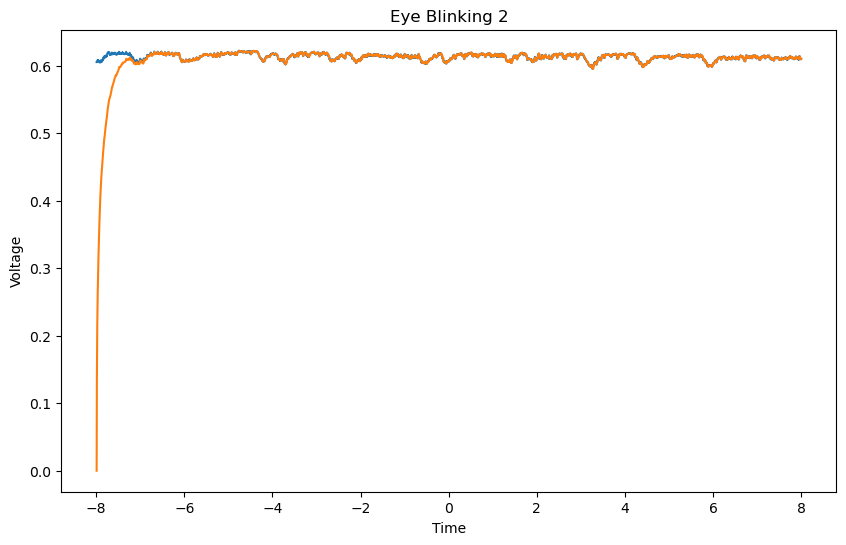

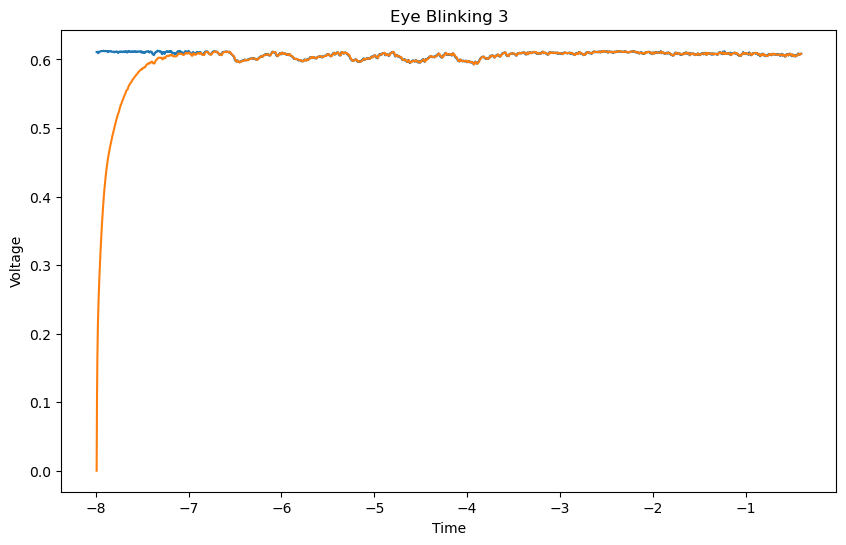

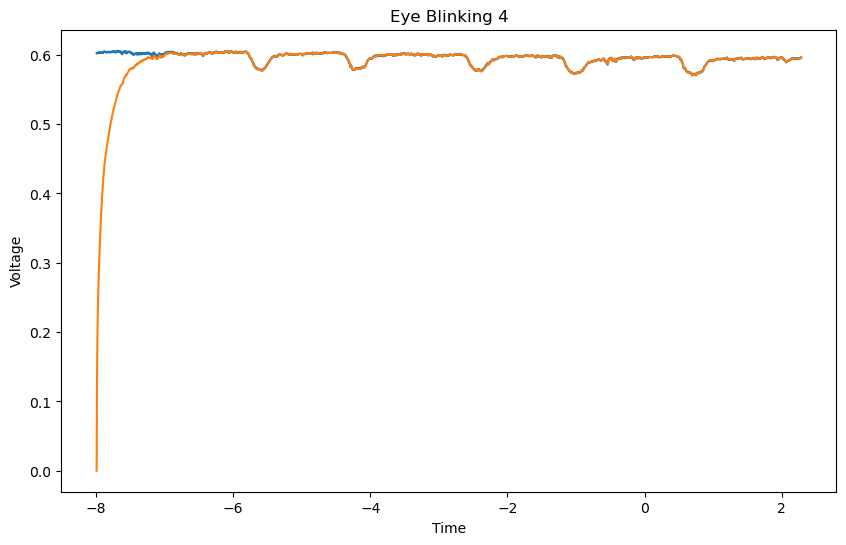

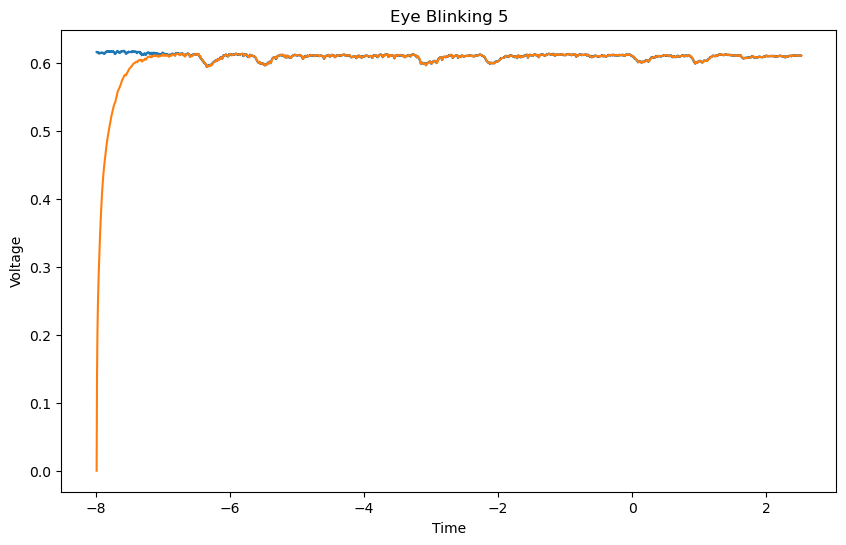

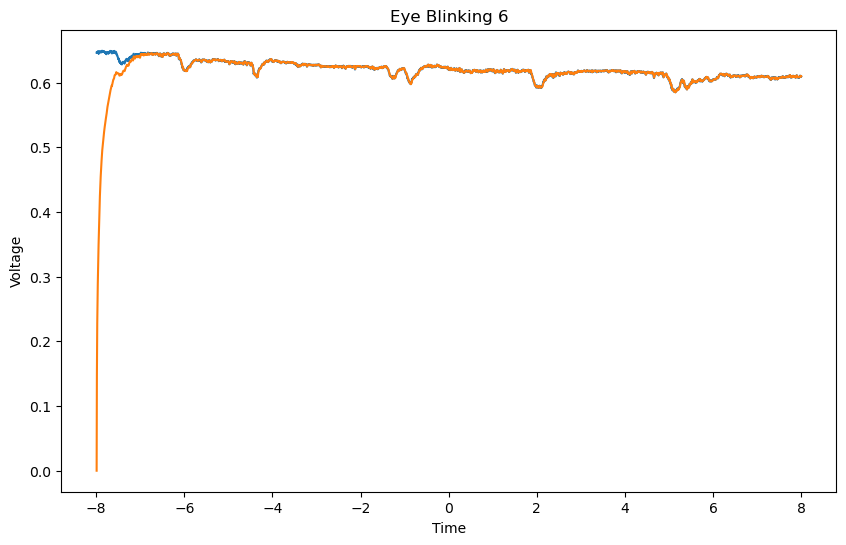

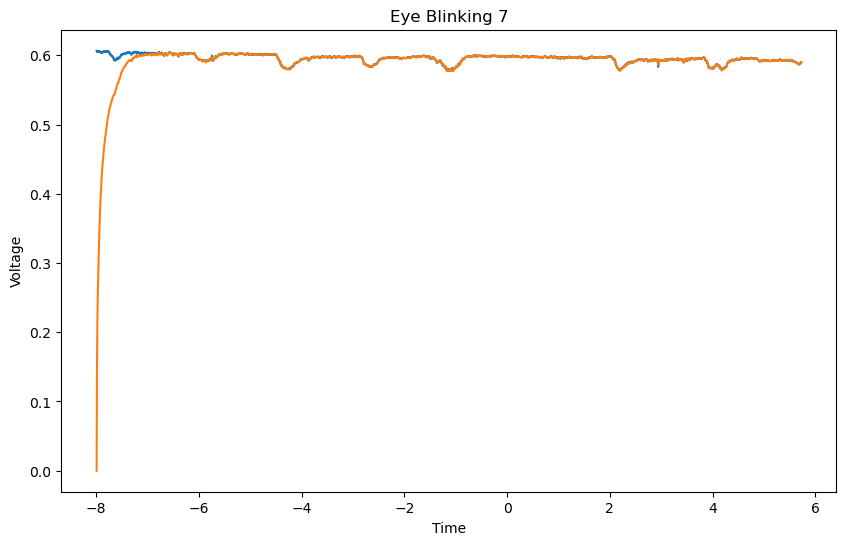

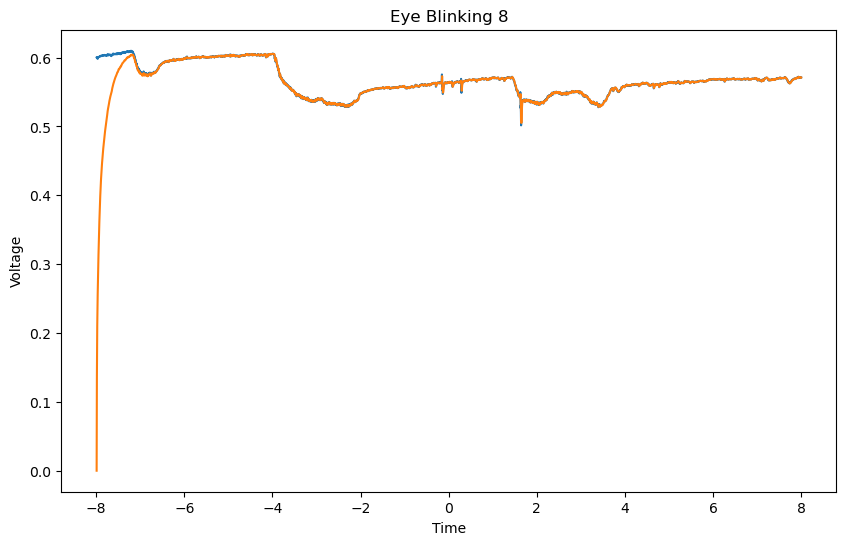

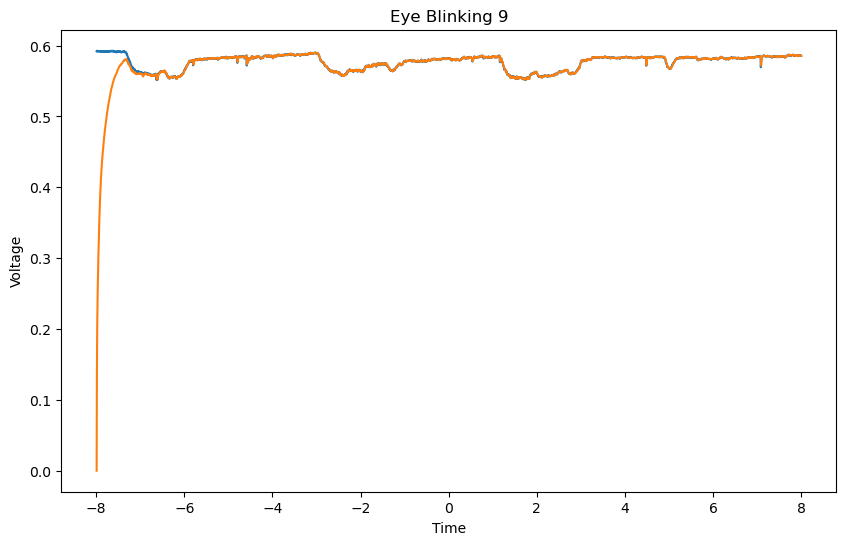

In [7]:
for i in range(10):
    data = pd.read_csv(f'output{i}.csv', delimiter=',')

    plt.figure(figsize=(10, 6))
    plt.plot(data['Time'], data['TrueVoltage'])
    plt.plot(data['Time'], data['Prediction'])

    plt.title(f'Eye Blinking {i}')
    plt.xlabel('Time')
    plt.ylabel('Voltage')
    plt.title(f'Eye Blinking {i}')
    plt.show()